In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product

In [2]:
DATA = Path("..","data","processed")
SECTORS = ["E", "H", "EH"]
PRICES = ["high", "mid", "low", "vlow"]
EMISSIONS = ["20", "35", "50"]
EMISSION_NICE_NAMES = {
    "er20":"20% Reduction",
    "er35":"35% Reduction",
    "er50":"50% Reduction",
}
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical and Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very Low",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [3]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    if not (sector or price):
        scenario = f"er{emission}"
    else:
        scenario = f"{sector}dr-{price}-er{emission}" 
    p = Path(DATA, scenario, "datapoint", f"{result}.csv")
    return pd.read_csv(p, index_col=0)

In [4]:
def get_scatter_data(result: str, metric: str) -> pd.DataFrame:
    
    data = {}
    
    for emission in EMISSIONS:
        e_data = []
        for sector, price in product(SECTORS, PRICES):
            costs = get_dataframe(
                emission=emission,
                result="cost",
                sector=sector,
                price=price
            )
            df = get_dataframe(
                emission=emission,
                result=result,
                sector=sector,
                price=price
            )
        
            obj = costs.at["objective", "value"] / 1e9
            datapoint = df.at[metric, "value"]
        
            e_data.append([obj, datapoint, sector, price])

        data[f"er{emission}"] = pd.DataFrame(
            e_data, 
            columns=[
                "Objective",
                metric,
                "Sector",
                "Price"
            ]
        )
    
    return data

In [5]:
def generate_scatterplot(data: dict[str, pd.DataFrame], ylabel: Optional[str] = None, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    fig, axs = plt.subplots(1,3, sharey=True)
    
    ax = 0
    handles, labels = [], []
    
    for er, df in data.items():
        df["Sector"] = df.Sector.map(SECTOR_NICE_NAMES)
        df["Price"] = df.Price.map(PRICE_NICE_NAMES)
        metric = df.columns[1]
        scatter = sns.scatterplot(data=df, x="Objective", y=metric, hue="Sector", style="Price", ax=axs[ax], legend=True, s=50)
        axs[ax].set_title(EMISSION_NICE_NAMES[er])
        axs[ax].set_ylabel("")
        axs[ax].set_xlabel("")
        
        # Collect handles and labels for shared legend
        h, l = scatter.get_legend_handles_labels()
        if not handles:  # Avoid duplicates by only collecting from the first plot
            handles, labels = h, l
            
        axs[ax].legend_.remove()
        
        ax += 1

    fig.legend(
        handles, 
        labels, 
        loc="center left", 
        bbox_to_anchor=(1, 0.5),  # Position to the right of the figure
        ncol=1, 
        frameon=False,
    )
    
    fig.supxlabel("Objective Cost ($B)")
    if ylabel:
        fig.supylabel(ylabel)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    
    return fig, axs

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': '20% Reduction'}>,
        <Axes: title={'center': '35% Reduction'}>,
        <Axes: title={'center': '50% Reduction'}>], dtype=object))

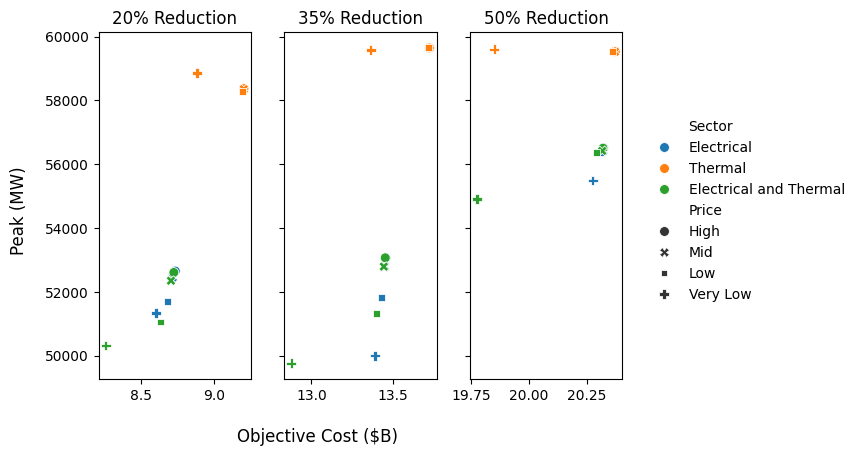

In [6]:
data = get_scatter_data("peakiness", "peak")
generate_scatterplot(data, ylabel = "Peak (MW)")


(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': '20% Reduction'}>,
        <Axes: title={'center': '35% Reduction'}>,
        <Axes: title={'center': '50% Reduction'}>], dtype=object))

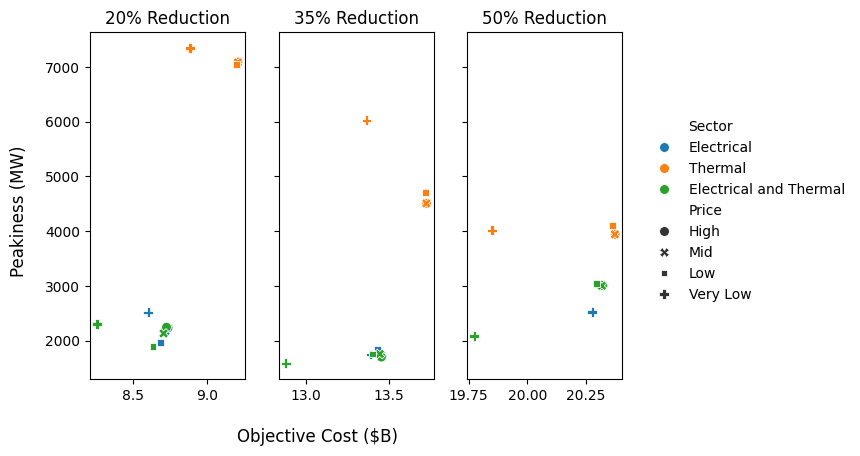

In [7]:
data = get_scatter_data("peakiness", "peakiness")
generate_scatterplot(data, ylabel = "Peakiness (MW)")

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': '20% Reduction'}>,
        <Axes: title={'center': '35% Reduction'}>,
        <Axes: title={'center': '50% Reduction'}>], dtype=object))

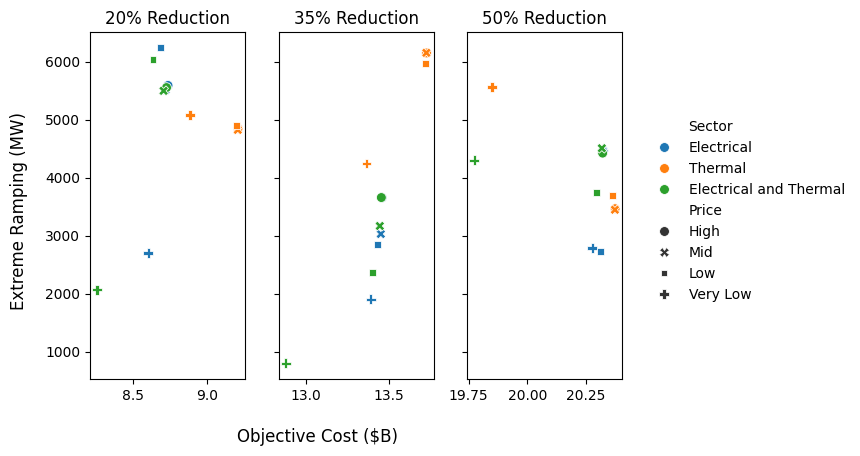

In [8]:
data = get_scatter_data("ramping", "peakiness")
generate_scatterplot(data, ylabel = "Extreme Ramping (MW)")

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': '20% Reduction'}>,
        <Axes: title={'center': '35% Reduction'}>,
        <Axes: title={'center': '50% Reduction'}>], dtype=object))

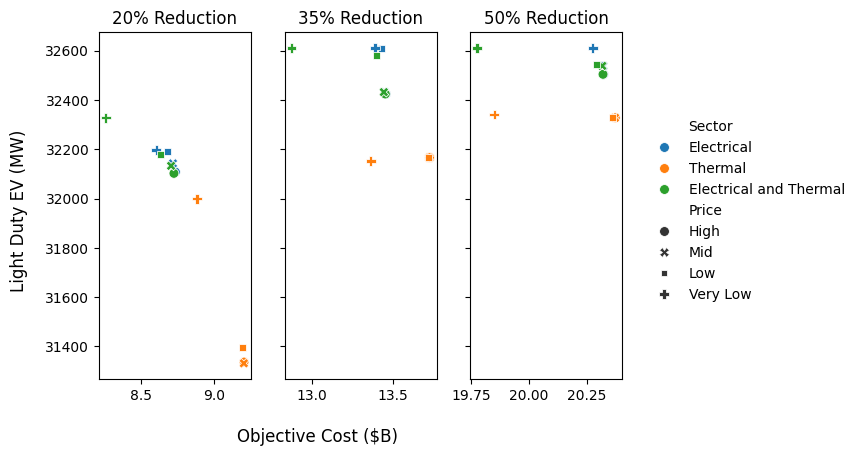

In [9]:
data = get_scatter_data("capacity", "Transport Electric Light")
generate_scatterplot(data, ylabel = "Light Duty EV (MW)")

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': '20% Reduction'}>,
        <Axes: title={'center': '35% Reduction'}>,
        <Axes: title={'center': '50% Reduction'}>], dtype=object))

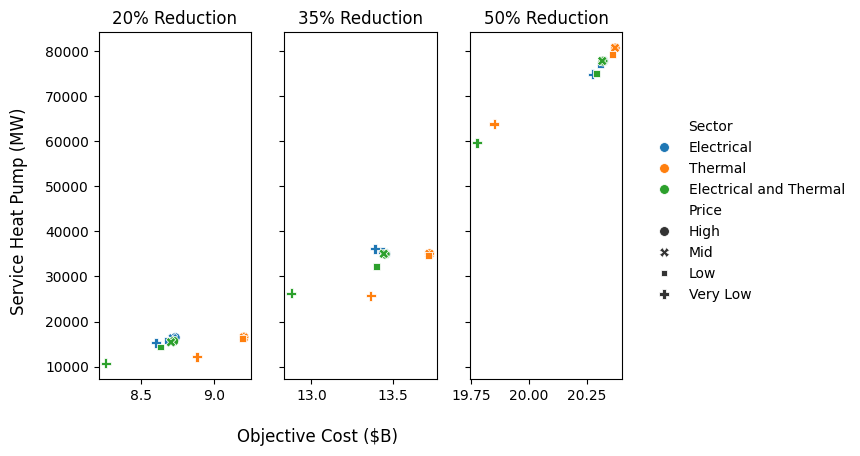

In [10]:
data = get_scatter_data("capacity", "Service Heat Pump")
generate_scatterplot(data, ylabel = "Service Heat Pump (MW)")

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': '20% Reduction'}>,
        <Axes: title={'center': '35% Reduction'}>,
        <Axes: title={'center': '50% Reduction'}>], dtype=object))

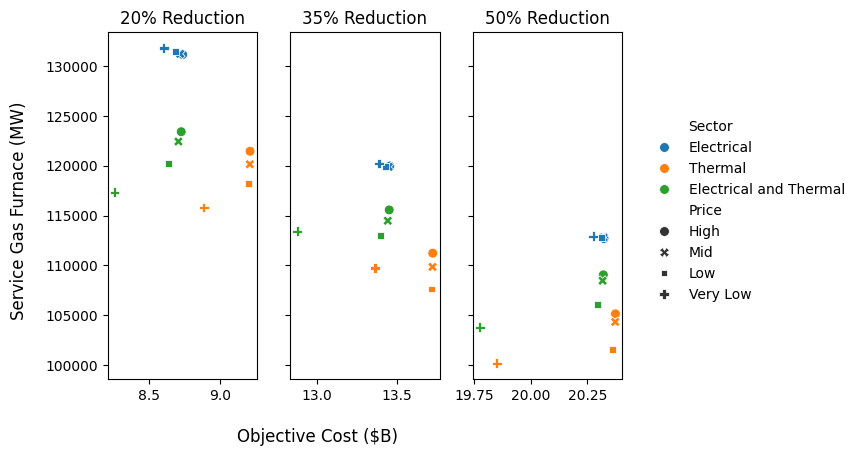

In [11]:
data = get_scatter_data("capacity", "Service Gas Furnace")
generate_scatterplot(data, ylabel = "Service Gas Furnace (MW)")